In [1]:
import matplotlib.pyplot as plt

from cordex.regions import _address
from cordex.regions import germany
from cordex import domain as dm

In [2]:
%matplotlib inline

In [ ]:
laender_mask = germany.VG2500.regionmask()
laender_geodata = germany.VG2500.geodata()
kreise_mask = germany.VG2500.regionmask('krs')

In [ ]:
fig,ax = plt.subplots(figsize=(13,10))
laender_mask.plot()

In [ ]:
fig,ax = plt.subplots(figsize=(13,10))
kreise_mask.plot()

In [14]:
import regionmask
land = regionmask.defined_regions.natural_earth.countries_110

In [27]:
land

<regionmask.Regions>
Name:     Natural Earth Countries: 110m
Source:   http://www.naturalearthdata.com

Regions:
   0  FJ                      Fiji
   1  TZ                  Tanzania
   2  WS                 W. Sahara
   3  CA                    Canada
   4  US  United States of America
...   ..                       ...
 172  RS                    Serbia
 173  ME                Montenegro
 174  KO                    Kosovo
 175  TT       Trinidad and Tobago
 176  SS                  S. Sudan

[177 regions]

In [3]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = SLURMCluster(name='dask-scheduler',
                       cores=4,                # Total number of cores per job
                       memory='16GB',          # Total amount of memory per job
                       processes=4,            # Number of Python processes per job
                       interface='ib0',        # Network interface to use like eth0 or ib0
                       queue='shared',      
                       project='ch0636',     
                       walltime='12:00:00',
                       asynchronous=0)
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p shared
#SBATCH -A ch0636
#SBATCH -n 1
#SBATCH --cpus-per-task=4
#SBATCH --mem=15G
#SBATCH -t 12:00:00

/work/ch0636/g300046/conda_envs/dask/bin/python -m distributed.cli.dask_worker tcp://10.50.40.231:38621 --nthreads 1 --nprocs 4 --memory-limit 4.00GB --name name --nanny --death-timeout 60 --interface ib0



In [4]:
cluster.scale(64)

In [5]:
client = Client(cluster)
client

Client Scheduler: tcp://10.50.40.231:38621 Dashboard: /user/g300046/advanced//proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [28]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm 
import intake
import fsspec
import seaborn as sns
import pandas as pd


dkrz_url = "/work/ik1017/Catalogs/mistral-cmip6.json"
pangeo_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(dkrz_url)
col

/work/ch0636/g300046/conda_envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  
Task exception was never retrieved
future: <Task finished coro=<connect.<locals>._() done, defined at /work/ch0636/g300046/conda_envs/dask/lib/python3.7/site-packages/distributed/comm/core.py:288> exception=CommClosedError()>
Traceback (most recent call last):
  File "/work/ch0636/g300046/conda_envs/dask/lib/python3.7/site-packages/distributed/comm/core.py", line 297, in _
    handshake = await asyncio.wait_for(comm.read(), 1)
  File "/work/ch0636/g300046/conda_envs/dask/lib/python3.7/asyncio/tasks.py", line 435, in wait_for
    await waiter
concurrent.futures._base.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/work/ch0636/g300046/conda_envs/dask/lib/python3.7/site-pac

,unique
activity_id,19
institution_id,39
source_id,97
experiment_id,214
member_id,420
table_id,38
variable_id,1171
grid_label,12
dcpp_init_year,61
version,603


In [29]:
[eid for eid in col.df['experiment_id'].unique() if 'ssp' in eid]

['ssp370',
 'ssp370-lowNTCF',
 'ssp370SST',
 'ssp370SST-lowNTCF',
 'ssp370SST-lowBC',
 'ssp370SST-ssp126Lu',
 'ssp370SST-lowAer',
 'ssp370SST-lowCH4',
 'ssp370pdSST',
 'esm-ssp585',
 'ssp534-over-bgc',
 'ssp585-bgc',
 'ssp126',
 'ssp245',
 'ssp585',
 'ssp245-GHG',
 'ssp245-aer',
 'ssp245-nat',
 'ssp245-stratO3',
 'ssp245-cov-fossil',
 'ssp245-cov-modgreen',
 'ssp245-cov-strgreen',
 'ssp245-covid',
 'ssp585-withism',
 'esm-ssp585-ssp126Lu',
 'ssp126-ssp370Lu',
 'ssp370-ssp126Lu',
 'ssp119',
 'ssp434',
 'ssp460',
 'ssp534-over']

In [30]:
# there is currently a significant amount of data for these runs
expts = ['historical', 'ssp126', 'ssp245', 'ssp585']

query = dict(
    experiment_id=expts,
    table_id='Amon',                           
    variable_id=['tas'],
    member_id = 'r1i1p1f1',                     
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id"]
].nunique()

,experiment_id,variable_id,table_id
source_id,,,
ACCESS-CM2,4,1,1
ACCESS-ESM1-5,4,1,1
AWI-CM-1-1-MR,4,1,1
BCC-CSM2-MR,4,1,1
CAMS-CSM1-0,4,1,1
CESM2,4,1,1
CESM2-WACCM,4,1,1
CIESM,4,1,1
CMCC-CM2-SR5,4,1,1


In [31]:
col_subset.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path,opendap_url
0,CMIP,CSIRO-ARCCSS,ACCESS-CM2,historical,r1i1p1f1,Amon,tas,gn,NaN,v20191108,185001-201412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/...
1,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp126,r1i1p1f1,Amon,tas,gn,NaN,v20191108,201501-210012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/Scena...
2,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp245,r1i1p1f1,Amon,tas,gn,NaN,v20191108,201501-210012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/Scena...
3,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp585,r1i1p1f1,Amon,tas,gn,NaN,v20191108,201501-210012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/Scena...
4,CMIP,CSIRO,ACCESS-ESM1-5,historical,r1i1p1f1,Amon,tas,gn,NaN,v20191115,185001-201412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525,ScenarioMIP,NCC,NorESM2-MM,ssp585,r1i1p1f1,Amon,tas,gn,NaN,v20191108,205101-206012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/Scena...
1526,ScenarioMIP,NCC,NorESM2-MM,ssp585,r1i1p1f1,Amon,tas,gn,NaN,v20191108,206101-207012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/Scena...
1527,ScenarioMIP,NCC,NorESM2-MM,ssp585,r1i1p1f1,Amon,tas,gn,NaN,v20191108,207101-208012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/Scena...
1528,ScenarioMIP,NCC,NorESM2-MM,ssp585,r1i1p1f1,Amon,tas,gn,NaN,v20191108,208101-209012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/Scena...


In [32]:
import datetime as dt

drops = ['_bounds', '_bnds', 'bnds']

def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds
                 if any(drop in vname for drop in drops)]
    drop_coords = [coord for coord in ds.coords
                 if any(drop in coord for drop in drops)]
    return ds.drop(drop_vars+drop_coords)

def open_dset(df):

    print(df.agg('path').values)
    ds = xr.open_mfdataset(df.agg('path').values, use_cftime=True)
#    ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True)
    return drop_all_bounds(ds)
#    return ds

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = defaultdict(dict) 

for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

In [33]:
dsets_ = dask.compute(dict(dsets))[0]

In [34]:
dsets_.keys()

dict_keys(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2', 'CESM2-WACCM', 'CIESM', 'CMCC-CM2-SR5', 'CanESM5', 'EC-Earth3', 'EC-Earth3-Veg', 'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-ESM4', 'IITM-ESM', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'KACE-1-0-G', 'KIOST-ESM', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM'])

In [35]:
dsets_['MPI-ESM1-2-HR']['historical']

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 384, time: 1980)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat      (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon      (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
    height   float64 2.0
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(60, 192, 384), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-mpi-esm@dkrz.de
    creation_date:          2019-08-25T06:42:07Z
    data_specs_version:     01.00.30
    experiment:             all-forcing simulation of the recent past
    experiment_id:          historical
    external_variables:     areacella
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.MPI-M.MPI-ES...
    grid:                   gn
    grid_label:             gn
    history:                2019-08-25T06:42:07Z ; CMOR rewrote data to be co...
    initialization_index:   1
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    institution_id:         MPI-M
    mip_era:                CMIP6
    nominal_resolution:     100 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       MPI-ESM1-2-HR
    parent_time_units:      days since 1850-1-1 00:00:00
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    project_id:             CMIP6
    realization_index:      1
    realm:                  atmos
    references:             MPI-ESM: Mauritsen, T. et al. (2019), Development...
    source:                 MPI-ESM1.2-HR (2017): \naerosol: none, prescribed...
    source_id:              MPI-ESM1-2-HR
    source_type:            AOGCM
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Amon
    table_info:             Creation Date:(09 May 2019) MD5:e6ef8ececc8f33864...
    title:                  MPI-ESM1-2-HR output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/68498095-cf29-4fb6-981a-ac9e3541d2cf

In [36]:
dsets_['GFDL-ESM4']['historical']

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 288, time: 1980)
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(1200, 180, 288), meta=np.ndarray>
Attributes:
    external_variables:     areacella
    history:                File was processed by fremetar (GFDL analog of CM...
    table_id:               Amon
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    contact:                gfdl.climate.model.info@noaa.gov
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    creation_date:          2019-07-26T20:13:55Z
    data_specs_version:     01.00.27
    experiment:             all-forcing simulation of the recent past
    experiment_id:          historical
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NOAA-GFDL.GF...
    grid:                   atmos data regridded from Cubed-sphere (c96) to 1...
    grid_label:             gr1
    initialization_index:   1
    institution:            National Oceanic and Atmospheric Administration, ...
    institution_id:         NOAA-GFDL
    license:                CMIP6 model data produced by NOAA-GFDL is license...
    mip_era:                CMIP6
    nominal_resolution:     100 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       GFDL-ESM4
    parent_time_units:      days since 0001-1-1
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  atmos
    source:                 GFDL-ESM4 (2018):\natmos: GFDL-AM4.1 (Cubed-spher...
    source_id:              GFDL-ESM4
    source_type:            AOGCM AER CHEM BGC
    sub_experiment:         none
    sub_experiment_id:      none
    title:                  NOAA GFDL GFDL-ESM4 model output prepared for CMI...
    tracking_id:            hdl:21.14100/75e5c5a7-d7c4-4860-beb1-db454f25f13a
    variable_id:            tas
    variant_info:           N/A
    references:             see further_info_url attribute
    variant_label:          r1i1p1f1

In [75]:
# calculate global means
import datetime as dt

DT = slice(dt.datetime(1900,1,1), dt.datetime(2100,12,31))

def set_regionmask_labels(ds, region):
    """Set names as region label for region dimension from regionmask regions."""
    abbrevs = region[ds.region.values].abbrevs
    names = region[ds.region.values].names
    ds.coords["abbrevs"] = ("region", abbrevs)
    ds.coords["number"] = ("region", ds.region.values)
    ds["region"] = names
    return ds

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def get_lon_name(ds):
    for lat_name in ['lon', 'longitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a longitude coordinate")
    
def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

def set_datetime_index(ds):
    datetimeindex = ds.indexes['time'].to_datetimeindex()
    ds['time'] = datetimeindex
    return ds

def mask_mean(ds, regions):
    lat_name = get_lat_name(ds)
    lon_name = get_lon_name(ds)
    lat = ds[lat_name]
    lon = ds[lon_name]
    print(lat_name, lon_name)
    mask = regions.mask(ds, lon_name=lon_name, lat_name=lat_name)
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    ds_country = (ds*weight).groupby(mask).mean('stacked_{}_{}'.format(lat_name, lon_name), keep_attrs=True)
    ds_country = set_regionmask_labels(ds_country, regions)
    #ds_country = set_datetime_index(ds_country)
    return ds_country
    #weight = np.cos(np.deg2rad(lat))
    #weight /= weight.mean()
    #other_dims = set(ds.dims) - {'time'}
    #return (ds * weight).mean(other_dims)

In [38]:
import geopandas as gpd
url = "https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip"
country_shp = gpd.read_file(url).to_crs("EPSG:4326")

In [232]:
country_shp.NAME_EN.unique()

array(['Indonesia', 'Malaysia', 'Chile', 'Bolivia', 'Peru', 'Argentina',
       'Dhekelia Cantonment', 'Cyprus', 'India',
       "People's Republic of China", 'Israel', 'Palestine', 'Lebanon',
       'Ethiopia', 'South Sudan', 'Somalia', 'Kenya', 'Pakistan',
       'Malawi', 'Tanzania', 'Syria', 'Somaliland', 'France', 'Suriname',
       'Guyana', 'South Korea', 'North Korea', 'Morocco',
       'Western Sahara', 'Costa Rica', 'Nicaragua',
       'Republic of the Congo', 'Democratic Republic of the Congo',
       'Bhutan', 'Ukraine', 'Belarus', 'Namibia', 'South Africa',
       'Saint Martin', 'Sint Maarten', 'Oman', 'Uzbekistan', 'Kazakhstan',
       'Tajikistan', 'Lithuania', 'Brazil', 'Uruguay', 'Mongolia',
       'Russia', 'Czech Republic', 'Germany', 'Estonia', 'Latvia',
       'Norway', 'Sweden', 'Finland', 'Vietnam', 'Cambodia', 'Luxembourg',
       'United Arab Emirates', 'Belgium', 'Georgia',
       'Republic of Macedonia', 'Albania', 'Azerbaijan', 'Kosovo',
       'Turkey', 'S

In [213]:
country_shp.set_index('NAME_EN')

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry
NAME_EN,,,,,,,,,,,,,,,,,,,,,
Indonesia,Admin-0 country,5,2,Indonesia,IDN,0,2,Sovereign country,Indonesia,IDN,...,인도네시아,Indonesië,Indonezja,Indonésia,Индонезия,Indonesien,Endonezya,Indonesia,印度尼西亚,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
Malaysia,Admin-0 country,5,3,Malaysia,MYS,0,2,Sovereign country,Malaysia,MYS,...,말레이시아,Maleisië,Malezja,Malásia,Малайзия,Malaysia,Malezya,Malaysia,马来西亚,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."
Chile,Admin-0 country,6,2,Chile,CHL,0,2,Sovereign country,Chile,CHL,...,칠레,Chili,Chile,Chile,Чили,Chile,Şili,Chile,智利,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611..."
Bolivia,Admin-0 country,0,3,Bolivia,BOL,0,2,Sovereign country,Bolivia,BOL,...,볼리비아,Bolivia,Boliwia,Bolívia,Боливия,Bolivia,Bolivya,Bolivia,玻利維亞,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5..."
Peru,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,Peru,PER,...,페루,Peru,Peru,Peru,Перу,Peru,Peru,Peru,秘鲁,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Macau,Admin-0 country,0,4,China,CH1,1,2,Country,Macao S.A.R,MAC,...,마카오,Macau,Makau,Macau,Макао,Macao,Makao,Ma Cao,澳門,"MULTIPOLYGON (((113.55860 22.16303, 113.56943 ..."
Ashmore and Cartier Islands,Admin-0 country,6,5,Australia,AU1,1,2,Dependency,Ashmore and Cartier Islands,ATC,...,애시모어 카르티에 제도,Ashmore- en Cartiereilanden,Wyspy Ashmore i Cartiera,Ilhas Ashmore e Cartier,Острова Ашмор и Картье,Ashmore- och Cartieröarna,Ashmore ve Cartier Adaları,Quần đảo Ashmore và Cartier,阿什莫尔和卡捷岛,"POLYGON ((123.59702 -12.42832, 123.59775 -12.4..."
Bajo Nuevo Bank,Admin-0 country,6,8,Bajo Nuevo Bank (Petrel Is.),BJN,0,2,Indeterminate,Bajo Nuevo Bank (Petrel Is.),BJN,...,바호 누에보 뱅크,Bajo Nuevo,Bajo Nuevo,Ilha Baixo Novo,Бахо-Нуэво,Bajo Nuevo,Bajo Nuevo Bank,Bajo Nuevo Bank,巴霍努埃沃礁,"POLYGON ((-79.98929 15.79495, -79.98782 15.796..."


In [218]:
import regionmask
country_regions = regionmask.from_geopandas(country_shp, names='NAME_EN',abbrevs='_from_name')

<GeoAxesSubplot:>

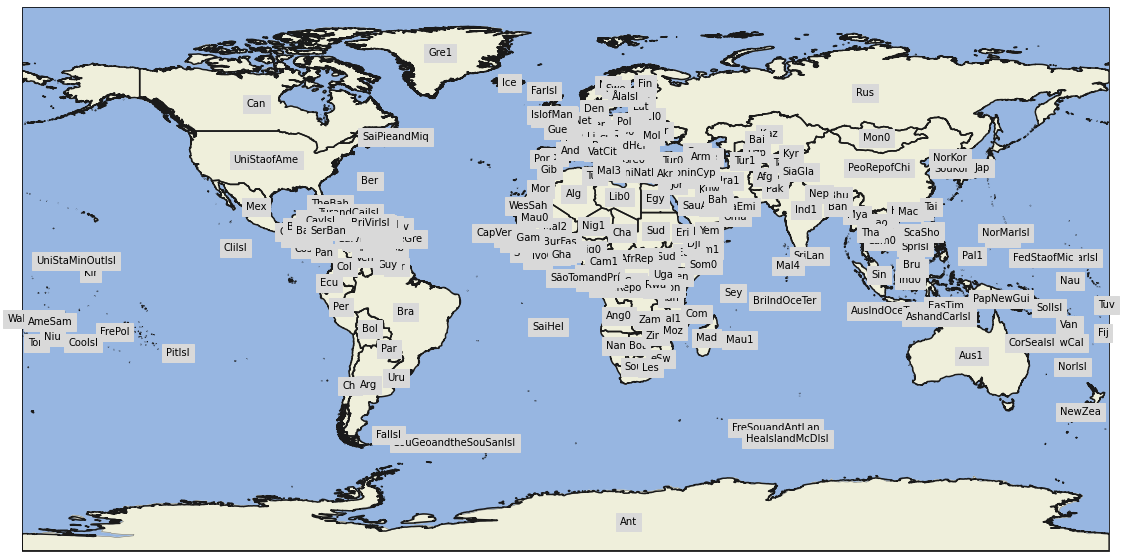

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots(figsize=(25,10))
country_regions.plot(label='abbrev',add_land=True, add_ocean=True)

In [269]:
country_regions['India']

Region: India (Ind1 / 8)
center: [79.58637149 22.91327738]

In [ ]:

gcm = dsets_['AWI-CM-1-1-MR']['historical']
gcm = dsets_['MPI-ESM1-2-HR']['historical']
mask = country_regions.mask(gcm, lon_name='lon', lat_name='lat')
filt = (country_shp['NAME_EN'] == 'United States of America')
idx = country_shp.index[filt][0] + 1
print(idx)
for name, group in gcm.groupby(mask):
    mean = (group.unstack().sortby(gcm.lon))#.mean(('lat', 'lon')))
    #mean.tas[0].plot()
    #region_mean = group.unstack().sortby(group.lon)
    #.sortby(gcm.lon).mean()
#set_regionmask_labels(ds_country, country_regions)

154


In [119]:
mask

<xarray.DataArray 'region' (lat: 192, lon: 384)>
array([[172., 172., 172., ..., 172., 172., 172.],
       [172., 172., 172., ..., 172., 172., 172.],
       [172., 172., 172., ..., 172., 172., 172.],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])
Coordinates:
  * lat      (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon      (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1

In [72]:
weighted_mean = (gcm*weight).mean(("lon", "lat")).groupby('time.year').mean()
weighted_mean

<xarray.Dataset>
Dimensions:  (year: 165)
Coordinates:
    height   float64 2.0
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014
Data variables:
    tas      (year) float64 dask.array<chunksize=(1,), meta=np.ndarray>

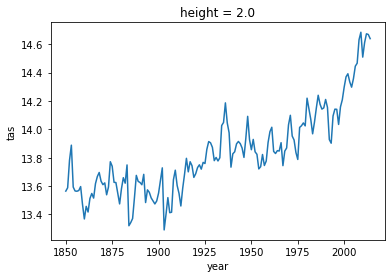

In [74]:
(weighted_mean.tas-273.5).plot()

In [ ]:
fig,ax = plt.subplots(figsize=(25,10))
(gcm.tas[0]-273).plot()

In [76]:
mask = country_regions.mask(gcm, lon_name='lon', lat_name='lat')

In [89]:
mask

<xarray.DataArray 'region' (lat: 192, lon: 384)>
array([[172., 172., 172., ..., 172., 172., 172.],
       [172., 172., 172., ..., 172., 172., 172.],
       [172., 172., 172., ..., 172., 172., 172.],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])
Coordinates:
  * lat      (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon      (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1

In [ ]:
mask.where(mask!=172, 'Indo')

In [ ]:
#fig,ax = plt.subplots(figsize=(25,10))
gcm['mask'] = mask

In [ ]:
country_regions[1]

In [81]:
country_mean = mask_mean(gcm, country_regions)
global_mean = global_mean(gcm)

lat lon


In [82]:
country_mean

<xarray.Dataset>
Dimensions:  (region: 174, time: 1980)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    height   float64 2.0
  * region   (region) <U35 'Indonesia' 'Malaysia' ... 'Vanuatu'
    abbrevs  (region) <U15 'Ind0' 'Mal0' 'Chi' 'Bol' ... 'SolIsl' 'FalIsl' 'Van'
    number   (region) float64 0.0 1.0 2.0 3.0 4.0 ... 232.0 233.0 239.0 240.0
Data variables:
    tas      (region, time) float64 dask.array<chunksize=(1, 60), meta=np.ndarray>

In [83]:
global_mean

<xarray.Dataset>
Dimensions:  (time: 1980)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    height   float64 2.0
Data variables:
    tas      (time) float64 dask.array<chunksize=(60,), meta=np.ndarray>

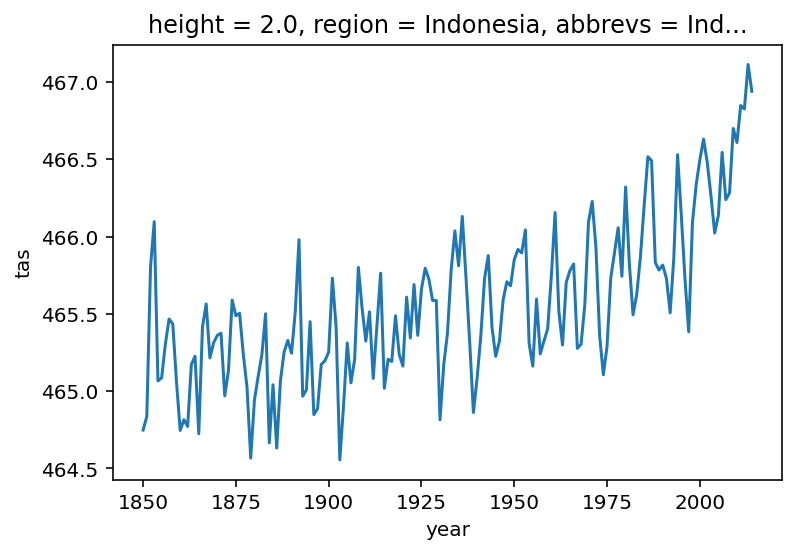

In [86]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina' 
country_mean.tas.sel(region='Indonesia').groupby('time.year').mean().plot()

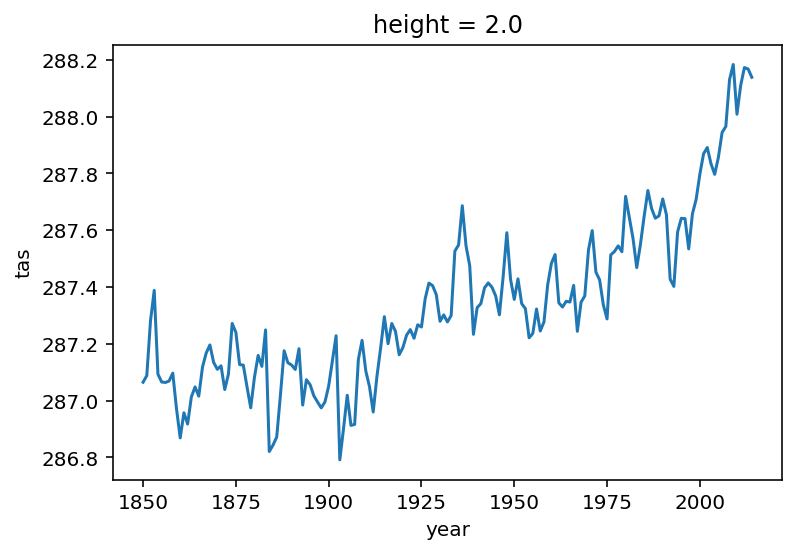

In [88]:
global_mean.tas.groupby('time.year').mean().plot()

In [ ]:
datetimeindex = country_mean.indexes['time'].to_datetimeindex()
country_mean['time'] = datetimeindex

In [ ]:
df = country_mean.to_dataframe().reset_index()

In [ ]:
df

In [ ]:
df.info()

In [ ]:
df.to_csv('region-mean.csv')

In [ ]:
regions = ['Germany','United States of America','Niger','India',"People's Republic of China",'Russia','Australia','Egypt']
filt = df['region'] == 'Germany'
df_sel = df[filt]
mean = df_sel.groupby(df_sel.time.dt.year).mean()
mean['region'] = 'Germany'
mean

In [ ]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina' 

sns.relplot(data=mean,
            x="time", y="tas", hue='region',
            kind="line", ci="sd", aspect=2);

In [ ]:
import datetime as dt

expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                       coords={'experiment_id': expts})

dsets_aligned = {}

for k, v in tqdm(dsets_.items()):
    print(k)
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue
        
      
    for ds in expt_dsets:
       # time_axis = pd.to_datetime(["{:04d}-{:02d}-{:02d}".format(date.year, date.month, date.day) 
       #                             for date in ds.time.values])
       # time_axis = ([cftime.datetime(date.year, date.month, date.day, date.hour, date.minute, date.second)
       #                             for date in ds.time.values])
        time_axis = ([dt.datetime(date.year, date.month, date.day)
                                    for date in ds.time.values])
        ds.coords['time'] = time_axis      
        
    dsets_region_mean = [v[expt].pipe(mask_mean, regions=country_regions )
 #                            .swap_dims({'time': 'cftime'})
 #                            .drop('time')
 #                            .coarsen(year=12).mean()
                      for expt in expts]
   # dsets_aligned[k] = xr.concat(dsets_region_mean, join='outer',
   #                              dim=expt_da)
    dsets_aligned = xr.concat(dsets_region_mean, join='outer',
                              dim=expt_da)
    df = dsets_aligned.to_dataframe().reset_index()
    df['source_id'] = k
    df.to_csv(k+'.csv', index=False)

In [ ]:
df_access = dsets_aligned['ACCESS-CM2'].to_dataframe().reset_index()

In [ ]:
df_access

In [ ]:
df_kace = dsets_aligned['KACE-1-0-G'].to_dataframe().reset_index()

In [ ]:
df_kace

In [ ]:
df_gfdl = dsets_aligned['GFDL-ESM4'].to_dataframe().reset_index()

In [ ]:
df_gfdl

In [ ]:
gfdl = dsets_aligned['GFDL-ESM4']

In [ ]:
df_gfdl.info()

In [ ]:
from dask.diagnostics import progress
with progress.ProgressBar():
    dsets_aligned_ = dask.compute(dsets_aligned)[0]

In [ ]:
df_all = {}

for model, ds in tqdm(dsets_aligned.items()):
    df = ds.to_dataframe().reset_index()
    df['source_id'] = model
    df.to_csv(model+'.csv')



In [ ]:
client.shutdown()
client.close()

In [ ]:
print('hello')